0) Setup (install + API key)

In [2]:
!pip -q install --upgrade openai pandas numpy matplotlib

In [3]:
import os, sys
from importlib import import_module

# ⬅️ Put your key in Colab "Secrets" (Recommended: Runtime > Run all, then paste when prompted)
if "OPENAI_API_KEY" not in os.environ or not os.environ["OPENAI_API_KEY"]:
    os.environ["OPENAI_API_KEY"] = input("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx").strip() #Insert OpenAI API Key

# quick check
print("OpenAI key loaded:", "✓" if bool(os.environ.get("OPENAI_API_KEY")) else "✗")

KeyboardInterrupt: Interrupted by user

1) Utilities + synthetic data

Generates simple motor signals and helper functions.

In [4]:
import json, math, random, time, re
from dataclasses import dataclass
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

random.seed(7); np.random.seed(7)

def moving_avg(x, w=5): return np.convolve(x, np.ones(w)/w, mode='same')
def zscore(x):
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + 1e-8)
def cosine_sim(a, b):
    a = np.asarray(a); b = np.asarray(b)
    d = (np.linalg.norm(a)*np.linalg.norm(b) + 1e-8)
    return float(np.dot(a, b) / d)

def simulate_motor_series(n=600, fault="none"):
    t = np.arange(n)
    current = 10 + 0.3*np.sin(2*np.pi*t/120) + np.random.normal(0, 0.1, n)
    temp    = 40 + 0.5*np.sin(2*np.pi*t/200 + 0.4) + np.random.normal(0, 0.2, n)
    vib     = 0.2 + 0.02*np.sin(2*np.pi*t/60) + np.random.normal(0, 0.01, n)

    if fault == "winding_short":
        s = n//2; current[s:] += np.linspace(0.0, 4.0, n-s); temp[s:] += np.linspace(0.0, 12.0, n-s)
    elif fault == "bearing_friction":
        s = n//2; vib[s:] += np.linspace(0.0, 0.25, n-s); temp[s:] += np.linspace(0.0, 8.0, n-s); current[s:] += np.linspace(0.0, 0.8, n-s)
    elif fault == "overload":
        s = n//2; current[s:] += np.linspace(0.0, 2.0, n-s); temp[s:] += np.linspace(0.0, 7.0, n-s); vib[s:] += np.linspace(0.0, 0.05, n-s)
    elif fault == "sensor_drift":
        temp += np.linspace(0, 10, n)
    elif fault == "overvoltage":
        s = n//2; current[s:] += np.linspace(0.0, 3.5, n-s); vib[s:] += np.linspace(0.0, 0.06, n-s)
        temp[s + n//10:] += np.linspace(0.0, 6.0, n - (s + n//10))

    return pd.DataFrame({"t": t, "current": current, "temperature": temp, "vibration": vib})

def quick_plot(df, title):
    fig, axs = plt.subplots(3,1, figsize=(10,6), sharex=True)
    axs[0].plot(df.t, df.current); axs[0].set_ylabel("Current A")
    axs[1].plot(df.t, df.temperature); axs[1].set_ylabel("Temp °C")
    axs[2].plot(df.t, df.vibration); axs[2].set_ylabel("Vibration g"); axs[2].set_xlabel("Time")
    for a in axs: a.grid(alpha=.3)
    fig.suptitle(title); plt.show()


2) Perception layer

Smoothing + simple deltas and z-scores → features for reasoning.

In [5]:
@dataclass
class PerceptionOutput:
    features: dict
    notes: str

class Perception:
    def __init__(self, smooth_w=7): self.w=smooth_w
    def run(self, df: pd.DataFrame) -> PerceptionOutput:
        df_s = df.copy()
        for col in ["current","temperature","vibration"]:
            df_s[col+"_s"] = moving_avg(df[col].values, w=self.w)

        n = len(df_s); head = df_s.iloc[:n//3]; tail = df_s.iloc[-n//3:]
        feat = {}
        for ch in ["current_s","temperature_s","vibration_s"]:
            feat[f"{ch}_delta_mean"] = float(tail[ch].mean() - head[ch].mean())
            feat[f"{ch}_z_last"] = float(zscore(df_s[ch])[-1])

        notes=[]
        if feat["current_s_delta_mean"]>1.5 and feat["temperature_s_delta_mean"]>4.0 and feat["vibration_s_delta_mean"]<0.06:
            notes.append("Strong rise in current+temperature; vibration ~stable (electrical?)")
        if feat["vibration_s_delta_mean"]>0.12: notes.append("Vibration rising (mechanical friction?)")
        if abs(feat["temperature_s_delta_mean"])>3 and abs(feat["current_s_delta_mean"])<0.5:
            notes.append("Temperature drift with modest current (sensor drift?)")
        return PerceptionOutput(features=feat, notes=" | ".join(notes))


3) Reasoning layer (GPT-4 CoT + Reflection + Agreement)

Calls GPT-4 twice per sample: first CoT, then reflection/critique. Also computes agreement rate.

In [6]:
from openai import OpenAI
client = OpenAI()

class ReasoningLLM:
    HYPOTHESES = ["winding_short","bearing_friction","overload","sensor_drift","overvoltage"]

    def __init__(self, model="gpt-4-turbo", temperature=0.7, max_tokens=600, reflect_temperature=0.5, sleep=1.0):
        self.model=model; self.temperature=temperature; self.max_tokens=max_tokens
        self.reflect_temperature=reflect_temperature; self.sleep=sleep
        self.prior={h:1/len(self.HYPOTHESES) for h in self.HYPOTHESES}

    # Build prompts
    def _build_prompt(self, p: PerceptionOutput):
        f=p.features
        return (f"Motor current Δ: {f['current_s_delta_mean']:.2f}\n"
                f"Temperature Δ: {f['temperature_s_delta_mean']:.2f}\n"
                f"Vibration Δ: {f['vibration_s_delta_mean']:.3f}\n\n"
                "You are an expert manufacturing diagnostician.\n"
                "Reason step-by-step (chain of thought) to decide the most likely fault.\n"
                "Candidates: winding_short, bearing_friction, overload, sensor_drift, overvoltage.\n"
                "Conclude with: 'Final diagnosis: <fault_type>'.")
    def _build_reflection_prompt(self, trace:str):
        return ("You are a senior expert reviewing the reasoning below.\n"
                "Highlight inconsistencies and either confirm or revise the diagnosis.\n"
                "Use exactly one of:\n"
                " - 'Diagnosis confirmed: <fault_type>'\n"
                " - 'Revised diagnosis: <fault_type>'\n\n"
                "Reasoning:\n"
                "----------------\n"+trace+"\n----------------")

    # OpenAI call
    def _gpt(self, prompt, temperature):
        r = client.chat.completions.create(
            model=self.model, temperature=temperature, max_tokens=self.max_tokens,
            messages=[{"role":"system","content":"You are an expert industrial AI engineer."},
                      {"role":"user","content":prompt}]
        )
        return r.choices[0].message.content.strip()

    def _extract_h(self, text:str):
        t=text.lower()
        for h in self.HYPOTHESES:
            if h in t: return h
        m=re.search(r"(?:final|revised|confirmed)\s*diagnosis[:\-\s]+([a-z_]+)", t)
        return m.group(1) if m else "unknown"

    # One sample: CoT + reflection
    def generate_cot_trace(self, p: PerceptionOutput, reflect=True):
        first = self._gpt(self._build_prompt(p), self.temperature)
        initial = self._extract_h(first)
        final, agree = initial, True
        refl=""
        if reflect:
            try:
                refl = self._gpt(self._build_reflection_prompt(first), self.reflect_temperature)
                new = self._extract_h(refl)
                if new not in ("unknown", initial):
                    final=new; agree=False
            except Exception as e:
                refl=f"[Reflection failed: {e}]"
        combined = first + "\n\n--- Reflection ---\n" + refl
        return {"trace":combined, "initial":initial, "final":final, "agreement":agree}

    # k samples for self-consistency
    def sample_traces(self, p: PerceptionOutput, k=3, reflect=True):
        out=[]
        for i in range(k):
            try:
                out.append(self.generate_cot_trace(p, reflect=reflect))
            except Exception as e:
                print(f"[Warning] GPT-4 call {i+1}/{k} failed: {e}")
            time.sleep(self.sleep)
        return out


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

4) Verification layer (digital twin + self-consistency fusion)

Compares observed deltas to expected signatures and fuses with frequency (voting).

In [7]:
class DigitalTwin:
    EXPECT = {
        "winding_short":    dict(dI=2.5, dT=8.0, dV=0.02),
        "bearing_friction": dict(dI=0.8, dT=6.0, dV=0.18),
        "overload":         dict(dI=1.3, dT=4.5, dV=0.03),
        "sensor_drift":     dict(dI=0.2, dT=6.0, dV=0.00),
        "overvoltage":      dict(dI=2.2, dT=3.0, dV=0.04),
    }
    def verify(self, feat:dict, hyp:str)->float:
        if hyp not in self.EXPECT: return 0.0
        exp=self.EXPECT[hyp]
        obs=np.array([feat["current_s_delta_mean"], feat["temperature_s_delta_mean"], feat["vibration_s_delta_mean"]])
        exv=np.array([exp["dI"], exp["dT"], exp["dV"]])
        sim=cosine_sim(np.maximum(obs,0), np.maximum(exv,0))
        penalty=0.0
        for k,v in zip(["dI","dT","dV"], obs):
            if (v>0 and exp[k]<0) or (v<0 and exp[k]>0): penalty+=0.2
        return max(0.0, sim-penalty)

class Verifier:
    def __init__(self): self.twin=DigitalTwin()
    def self_consistency(self, hyps:list[str])->dict:
        c=Counter(hyps); tot=sum(c.values()); return {h:c[h]/tot for h in c}
    def combined_confidence(self, feat:dict, hyps:list[str])->dict:
        freq=self.self_consistency(hyps); conf={}
        for h in set(hyps):
            conf[h]=0.5*freq.get(h,0)+0.5*self.twin.verify(feat,h)
        return conf


5) Learning layer + Orchestrator

Stores verified cases, updates priors, returns self-trust (agreement + mean confidence)/2.

In [8]:
class Memory:
    def __init__(self, path="/content/cot_fd6_memory.json"):
        self.path=Path(path)
        self.data=json.loads(self.path.read_text()) if self.path.exists() else {"cases":[]}
    def add_case(self, features, label, traces):
        self.data["cases"].append({"features":features, "label":label, "traces":traces})
        self.path.write_text(json.dumps(self.data, indent=2))
    def empirical_priors(self):
        c=Counter([c["label"] for c in self.data["cases"]])
        tot=sum(c.values());
        return {k:v/tot for k,v in c.items()} if tot>0 else None

class CoTFD6:
    def __init__(self):
        self.perception=Perception()
        self.reasoner=ReasoningLLM()
        self.verifier=Verifier()
        self.memory=Memory()
        pri=self.memory.empirical_priors()
        if pri:
            for h in self.reasoner.prior:
                self.reasoner.prior[h]=0.7*self.reasoner.prior[h]+0.3*pri.get(h,0.0)

    def run_once(self, df:pd.DataFrame, samples=4, verbose=True):
        p=self.perception.run(df)
        if verbose:
            print("[Perception]", {k:round(v,3) for k,v in p.features.items()})
            if p.notes: print(" Notes:", p.notes)

        traces=self.reasoner.sample_traces(p, k=samples, reflect=True)
        initial=[t["initial"] for t in traces]
        final=[t["final"] for t in traces]
        agree=[t["agreement"] for t in traces]
        agreement_rate = sum(agree)/len(agree) if agree else 0.0
        if verbose:
            print(f"\n[Reasoning] Reflection agreement: {agreement_rate*100:.1f}%")
            print(" Initial:", initial)
            print(" Final  :", final)
            print("\n Example trace:\n", traces[0]["trace"][:700], "...\n")

        conf=self.verifier.combined_confidence(p.features, final)
        best=max(conf.items(), key=lambda kv: kv[1])[0]
        confidence=conf[best]
        mean_conf=np.mean(list(conf.values()))
        self_trust=0.5*(agreement_rate + mean_conf)

        self.memory.add_case(p.features, best, [t["trace"] for t in traces])
        # small prior update
        for h in self.reasoner.prior: self.reasoner.prior[h]*=0.98
        self.reasoner.prior[best]*=1.25
        s=sum(self.reasoner.prior.values())
        for h in self.reasoner.prior: self.reasoner.prior[h]/=s

        if verbose:
            print("[Verification] Confidences:", {k:round(v,3) for k,v in conf.items()})
            print(f"[Decision] {best} (confidence={confidence:.3f})")
            print(f"[Self-Trust] {self_trust:.3f}  (agreement={agreement_rate:.2f}, mean_conf={mean_conf:.2f})")
        return dict(perception=p.features, initial_hypotheses=initial, final_hypotheses=final,
                    confidences=conf, selected=best, confidence=confidence,
                    agreement_rate=agreement_rate, self_trust_score=self_trust)


6) Quick single-case demo

Run one scenario end-to-end; inspect prints + signal plots.

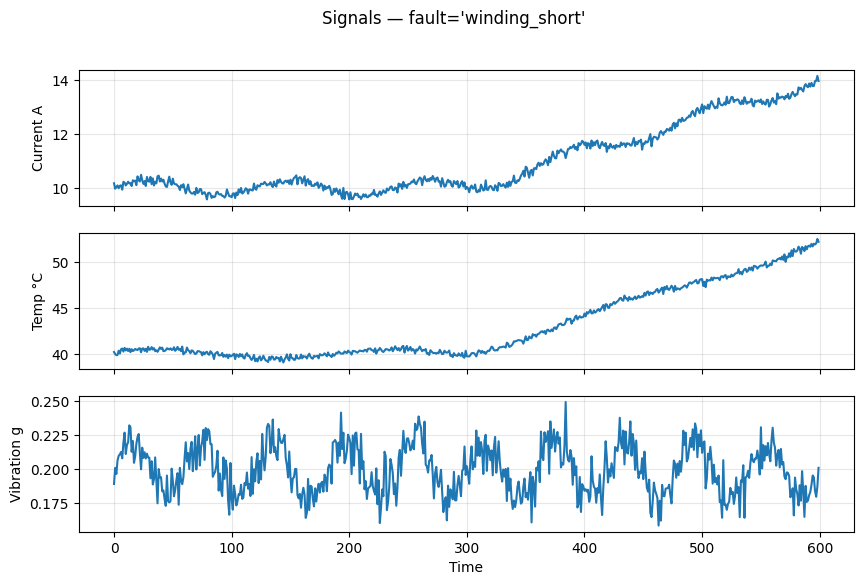

[Perception] {'current_s_delta_mean': 2.564, 'current_s_z_last': -2.276, 'temperature_s_delta_mean': 7.959, 'temperature_s_z_last': -3.302, 'vibration_s_delta_mean': -0.004, 'vibration_s_z_last': -5.798}
 Notes: Strong rise in current+temperature; vibration ~stable (electrical?)

[Reasoning] Reflection agreement: 100.0%
 Initial: ['winding_short', 'winding_short', 'bearing_friction']
 Final  : ['winding_short', 'winding_short', 'bearing_friction']

 Example trace:
 To diagnose the most likely fault based on the provided data changes - motor current Δ, temperature Δ, and vibration Δ - I will analyze each parameter change and correlate them with the potential fault candidates: winding_short, bearing_friction, overload, sensor_drift, and overvoltage.

1. **Motor Current Δ: 2.56** - This indicates an increase in the motor current. Typically, an increase in motor current suggests that the motor is consuming more power. This could be due to an increased load or a fault condition such as a wi

{'perception': {'current_s_delta_mean': 2.5641589525712742,
  'current_s_z_last': -2.2758286056552013,
  'temperature_s_delta_mean': 7.959228041538758,
  'temperature_s_z_last': -3.3019818345364302,
  'vibration_s_delta_mean': -0.0036539472796517924,
  'vibration_s_z_last': -5.797772768342074},
 'initial_hypotheses': ['winding_short', 'winding_short', 'bearing_friction'],
 'final_hypotheses': ['winding_short', 'winding_short', 'bearing_friction'],
 'confidences': {'bearing_friction': 0.5584504954105332,
  'winding_short': 0.7333126474886069},
 'selected': 'winding_short',
 'confidence': 0.7333126474886069,
 'agreement_rate': 1.0,
 'self_trust_score': np.float64(0.822940785724785)}

In [ ]:
cot = CoTFD6()

fault = "winding_short"  # try: bearing_friction / overload / sensor_drift / overvoltage
df = simulate_motor_series(600, fault)
quick_plot(df, f"Signals — fault='{fault}'")

out = cot.run_once(df, samples=3, verbose=True)
out


7) Cross-fault experiment + metric plots (Section 6 figures)

Runs several faults, then draws agreement, self-trust, and agreement vs. confidence plots.


=== Case: winding_short ===

=== Case: bearing_friction ===

=== Case: overload ===

=== Case: sensor_drift ===

=== Case: overvoltage ===


,true_fault,selected,agreement_%,mean_confidence,self_trust_score
0,winding_short,winding_short,33.333333,0.558236,0.445785
1,bearing_friction,overload,66.666667,0.744647,0.705657
2,overload,overload,100.000000,0.665084,0.832542
3,sensor_drift,overload,66.666667,0.590035,0.628351
4,overvoltage,overload,33.333333,0.489774,0.411554


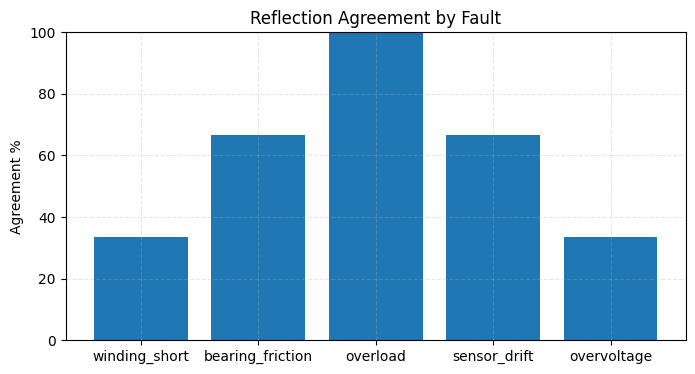

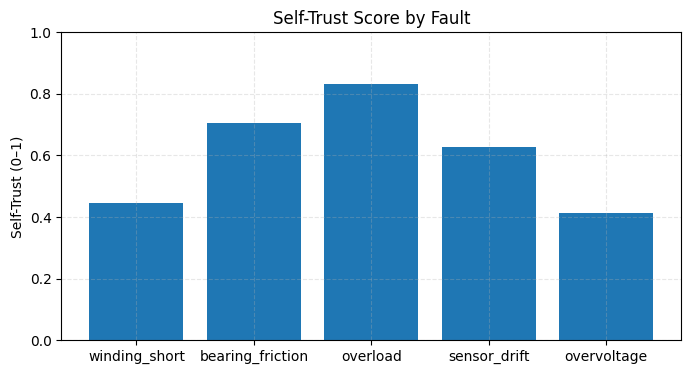

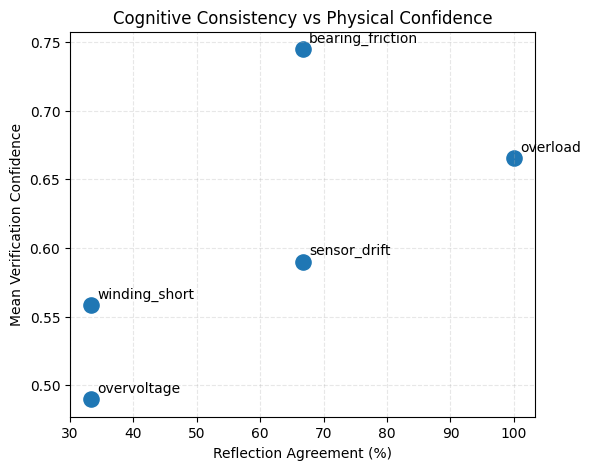

In [ ]:
faults = ["winding_short","bearing_friction","overload","sensor_drift","overvoltage"]
results_all=[]
for f in faults:
    df=simulate_motor_series(600, f)
    print(f"\n=== Case: {f} ===")
    results_all.append({**cot.run_once(df, samples=3, verbose=False), "true_fault":f})

df_res = pd.DataFrame(results_all)
df_res["agreement_%"] = df_res["agreement_rate"]*100
df_res["mean_confidence"] = df_res["confidences"].apply(lambda c: np.mean(list(c.values())))
display(df_res[["true_fault","selected","agreement_%","mean_confidence","self_trust_score"]])

# Plots
plt.figure(figsize=(8,4))
plt.bar(df_res["true_fault"], df_res["agreement_%"]); plt.ylim(0,100)
plt.title("Reflection Agreement by Fault"); plt.ylabel("Agreement %"); plt.grid(alpha=.3, ls="--"); plt.show()

plt.figure(figsize=(8,4))
plt.bar(df_res["true_fault"], df_res["self_trust_score"])
plt.title("Self-Trust Score by Fault"); plt.ylabel("Self-Trust (0–1)"); plt.ylim(0,1)
plt.grid(alpha=.3, ls="--"); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df_res["agreement_%"], df_res["mean_confidence"], s=120)
for i,row in df_res.iterrows():
    plt.annotate(row["true_fault"], (row["agreement_%"]+1, row["mean_confidence"]+0.005))
plt.xlabel("Reflection Agreement (%)"); plt.ylabel("Mean Verification Confidence")
plt.title("Cognitive Consistency vs Physical Confidence"); plt.grid(alpha=.3, ls="--"); plt.show()


8) Temporal self-improvement (learning over iterations)

Shows agreement & self-trust trending upward as memory grows.

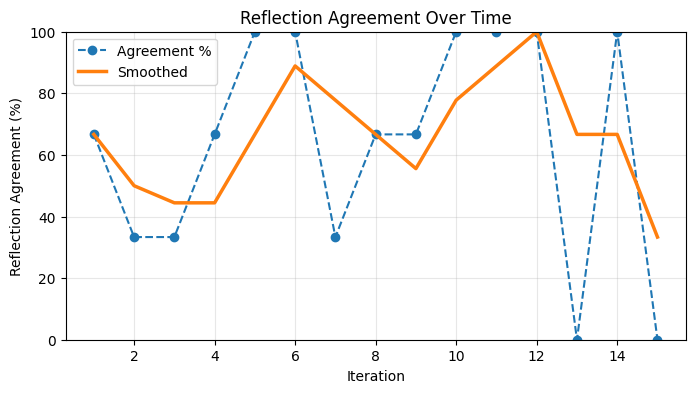

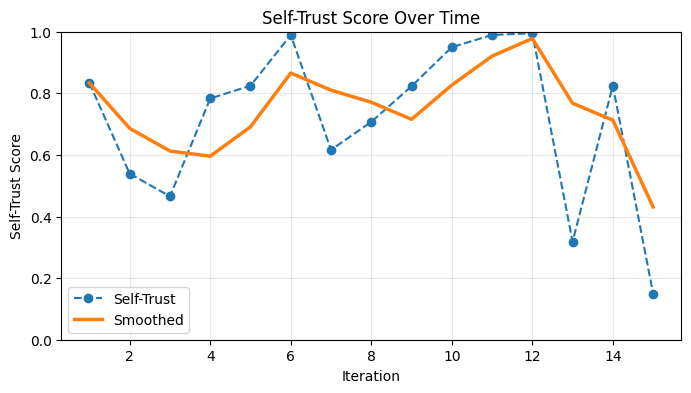

In [ ]:
iterations = 15
fault_pool = ["winding_short","bearing_friction","overload","sensor_drift","overvoltage"]
temporal=[]

for i in range(iterations):
    f=random.choice(fault_pool)
    df=simulate_motor_series(600, f)
    r=cot.run_once(df, samples=3, verbose=False)
    temporal.append({"iter":i+1, "fault":f, "agree":r["agreement_rate"], "selftrust":r["self_trust_score"]})

df_temp = pd.DataFrame(temporal)
df_temp["agree_%"] = df_temp["agree"]*100
df_temp["agree_smooth"] = df_temp["agree_%"].rolling(3, min_periods=1).mean()
df_temp["trust_smooth"] = df_temp["selftrust"].rolling(3, min_periods=1).mean()

# --- Reflection Agreement over time ---
plt.figure(figsize=(8,4))
plt.plot(df_temp["iter"], df_temp["agree_%"], "o--", label="Agreement %")
plt.plot(df_temp["iter"], df_temp["agree_smooth"], "-", lw=2.5, label="Smoothed")
plt.ylim(0, 100)
plt.xlabel("Iteration")
plt.ylabel("Reflection Agreement (%)")
plt.title("Reflection Agreement Over Time")
plt.grid(alpha=.3)
plt.legend()
plt.show()

# --- Self-Trust Score over time ---
plt.figure(figsize=(8,4))
plt.plot(df_temp["iter"], df_temp["selftrust"], "o--", label="Self-Trust")
plt.plot(df_temp["iter"], df_temp["trust_smooth"], "-", lw=2.5, label="Smoothed")
plt.ylim(0, 1)
plt.xlabel("Iteration")
plt.ylabel("Self-Trust Score")
plt.title("Self-Trust Score Over Time")
plt.grid(alpha=.3)
plt.legend()
plt.show()
